In [2]:
#Package loading
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, date, time, timedelta

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib import rc
from matplotlib.dates import date2num
from IPython import display
%matplotlib inline

from scipy import stats as sps
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import linear_model

import statsmodels.api as sm
from os import path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 18
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
plt.rc('font', family='serif')

In [4]:
df = pd.read_csv(r"./Data/"+"hchs_quest_pa_one_hot.csv")

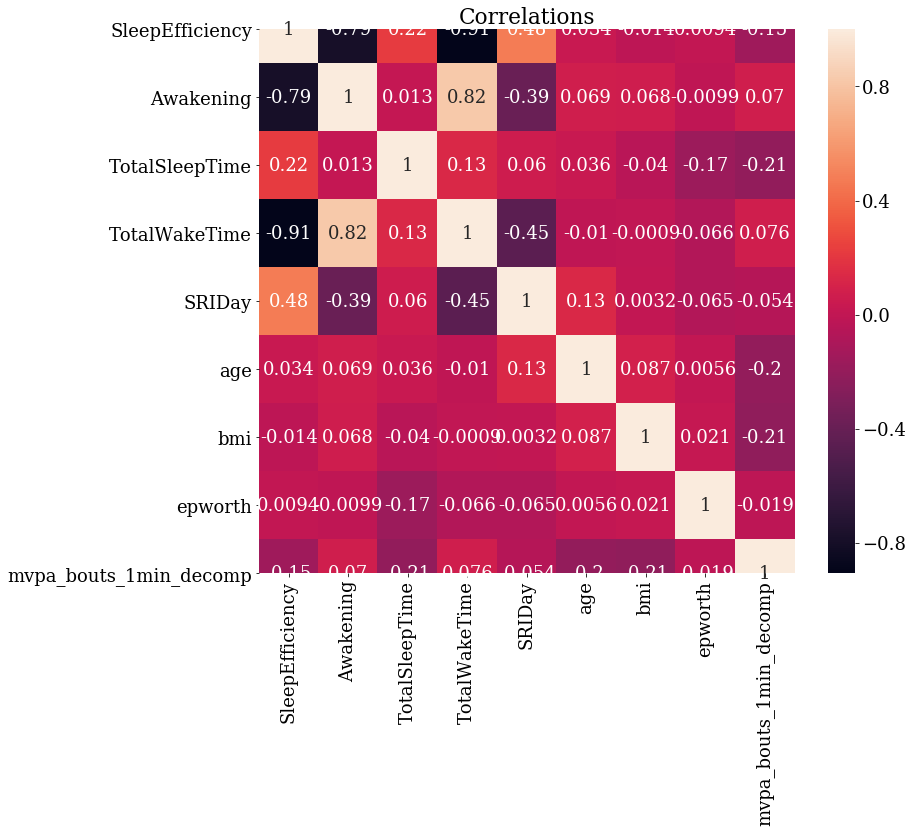

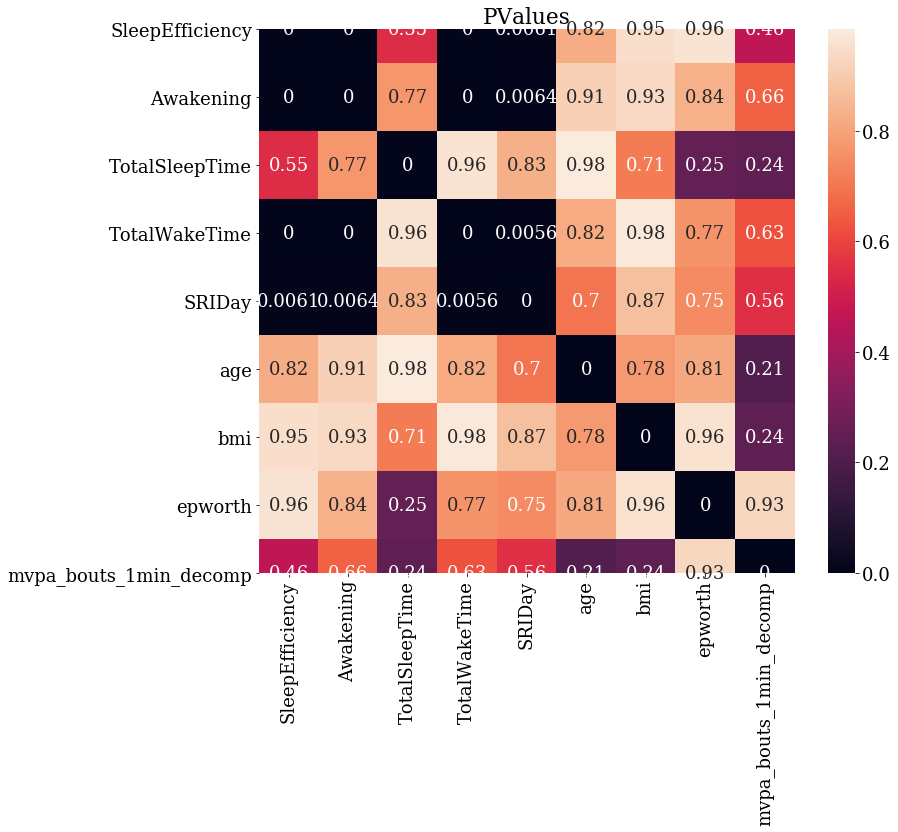

In [40]:
#Extracts Spearman's rank correlation on a day-by-day aggregate (over all subjects) of physical activity 
#and sleep parameters, plotting the r and p values in consecutive heatmaps, p vals rounded to 4 sig figures

X = df[['SleepEfficiency', 'Awakening', 'TotalSleepTime',
       'TotalWakeTime', 'SRIDay', 'age', 'bmi', 'epworth','mvpa_bouts_1min_decomp']]

#df_corrp = X.corr(method = 'pearson')
df_ranked = X.rank(method='max', ascending=False)
df_corrs = X.corr(method = 'spearman')

df_corrs_p = pd.DataFrame()  # Matrix of p-values
for x in df_corrs.columns:
    for y in df_corrs.columns:
        corr = sps.pearsonr(df_corrs[x], df_corrs[y])
        df_corrs_p.loc[x,y] = corr[1]

#print(ranks_agg)
plt.rcParams['figure.figsize'] = (12,10)
#sns.heatmap(df_corrp, annot=True)
#plt.show()
sns.heatmap(df_corrs, annot=True)
plt.title('Correlations')
plt.show()
sns.heatmap(np.round(df_corrs_p,4), annot=True)
plt.title('PValues')
plt.show()

In [41]:
#Base for regression pipeline, this time with 'real' data extracted earlier in the notebook
#print(df.head(5))
#I've left out most of the PA columns as the are highly correlated
df_nan = df[['SleepEfficiency', 'Awakening', 'TotalSleepTime',
       'TotalWakeTime', 'SRIDay', 'SRISleep', 'mvpa_bouts_1min_decomp',
        'mvpa_bouts_10min_decomp', 'vpa_bouts_1min_decomp', 'gender', 'age', 'bmi', 'cafe', 'tea',
       'cancer', 'ssleepd', 'epworth', 'whiirs', 'insomnia_sev', 'insomnia_sev_grp_2.0',
       'insomnia_sev_grp_3.0', 'insomnia_sev_grp_4.0', 'alcohol_2.0',
       'alcohol_3.0', 'cigar_2.0', 'cigar_3.0', 'cafe_wake_1', 'cafe_wake_2',
       'cafe_wake_3', 'cafe_wake_4', 'employ_2.0', 'employ_3.0', 'employ_4.0',
       'diabetes_2.0', 'diabetes_3.0', 'persontype_1', 'persontype_2',
       'persontype_3', 'persontype_4']]

scaled_features = ['SleepEfficiency', 'Awakening', 'TotalSleepTime',
       'TotalWakeTime', 'SRIDay', 'SRISleep', 'mvpa_bouts_1min_decomp',
        'mvpa_bouts_10min_decomp', 'vpa_bouts_1min_decomp', 'age', 'bmi', 'ssleepd', 'epworth', 'whiirs']

scaler = StandardScaler()
scaler.fit(df_nan[scaled_features])
df_scaled = pd.DataFrame(scaler.transform(df_nan[scaled_features]), columns=scaled_features)
#print(df_scaled)
df_zipped = pd.concat([df_nan.drop(scaled_features,axis=1),df_scaled],axis=1).dropna()

                            OLS Regression Results                            
Dep. Variable:         TotalSleepTime   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     45.02
Date:                Thu, 18 Jun 2020   Prob (F-statistic):          3.97e-185
Time:                        09:46:57   Log-Likelihood:                -913.02
No. Observations:                1002   AIC:                             1904.
Df Residuals:                     963   BIC:                             2096.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

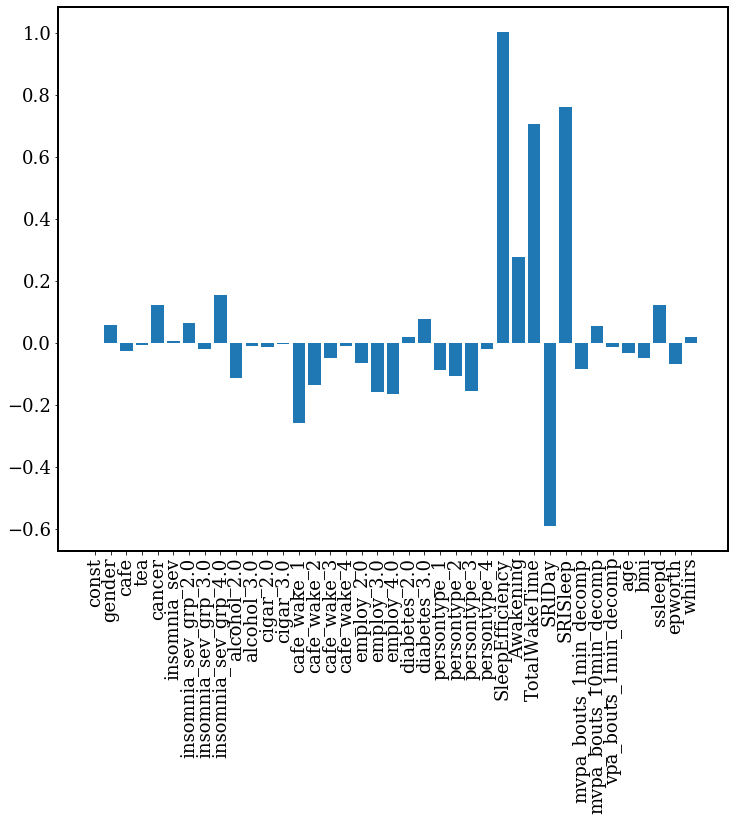

In [42]:
#Regression for TST
              
col1 = 'TotalSleepTime'
X_col1 = df_zipped.drop(col1,axis=1)
y_col1 = df_zipped[col1]

X_col1 = sm.add_constant(X_col1)

#Regression with sm
# Note the difference in argument order
model_col1 = sm.OLS(y_col1, X_col1).fit() ## sm.OLS(output, input)
predictions = model_col1.predict(X_col1)

# Print out the statistics
print(model_col1.summary())


#Regression with sklearn linear_model
lm = linear_model.LinearRegression()
model_lm_col1 = lm.fit(X_col1,y_col1)
predictions = lm.predict(X_col1)
#print(predictions)
importance = model_lm_col1.coef_
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([X_col1.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

                            OLS Regression Results                            
Dep. Variable:        SleepEfficiency   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     11.73
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           2.43e-54
Time:                        09:37:42   Log-Likelihood:                -1247.5
No. Observations:                1002   AIC:                             2569.
Df Residuals:                     965   BIC:                             2751.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

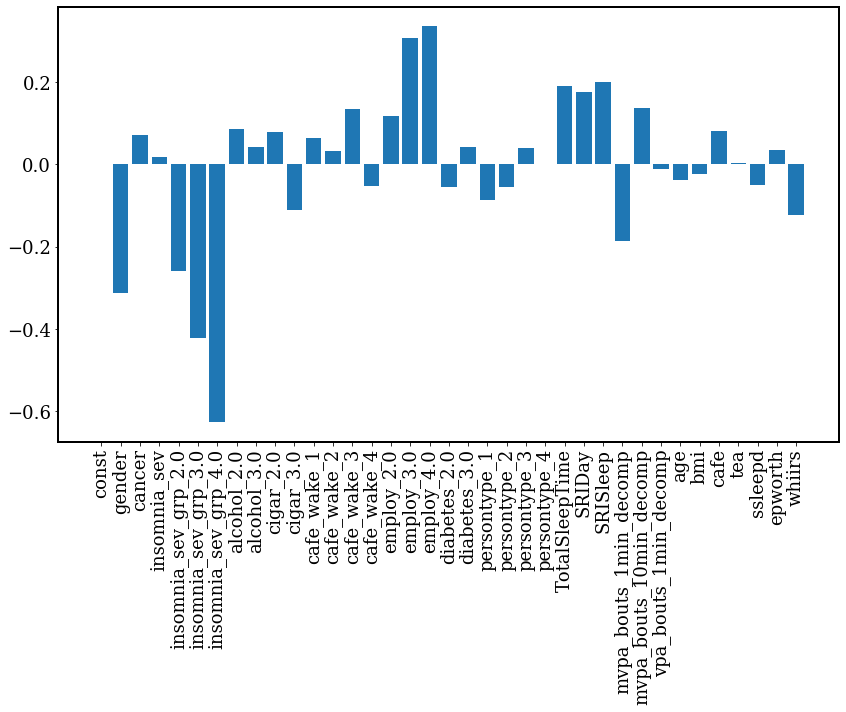

In [33]:
#Regression for SE
              
col2 = 'SleepEfficiency'
X_col2 = df_zipped.drop([col2,'TotalWakeTime','Awakening'],axis=1)
y_col2 = df_zipped[col2]

X_col2 = sm.add_constant(X_col2)

#Regression with sm
# Note the difference in argument order
model_col2 = sm.OLS(y_col2, X_col2).fit() ## sm.OLS(output, input)
predictions = model_col2.predict(X_col2)

# Print out the statistics
print(model_col2.summary())


#Regression with sklearn linear_model
lm = linear_model.LinearRegression()
model_lm_col2 = lm.fit(X_col2,y_col2)
predictions = lm.predict(X_col2)
#print(predictions)
importance = model_lm_col2.coef_
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([X_col2.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

                            OLS Regression Results                            
Dep. Variable:              Awakening   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     8.644
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           1.85e-38
Time:                        09:38:48   Log-Likelihood:                -1290.9
No. Observations:                1002   AIC:                             2656.
Df Residuals:                     965   BIC:                             2838.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

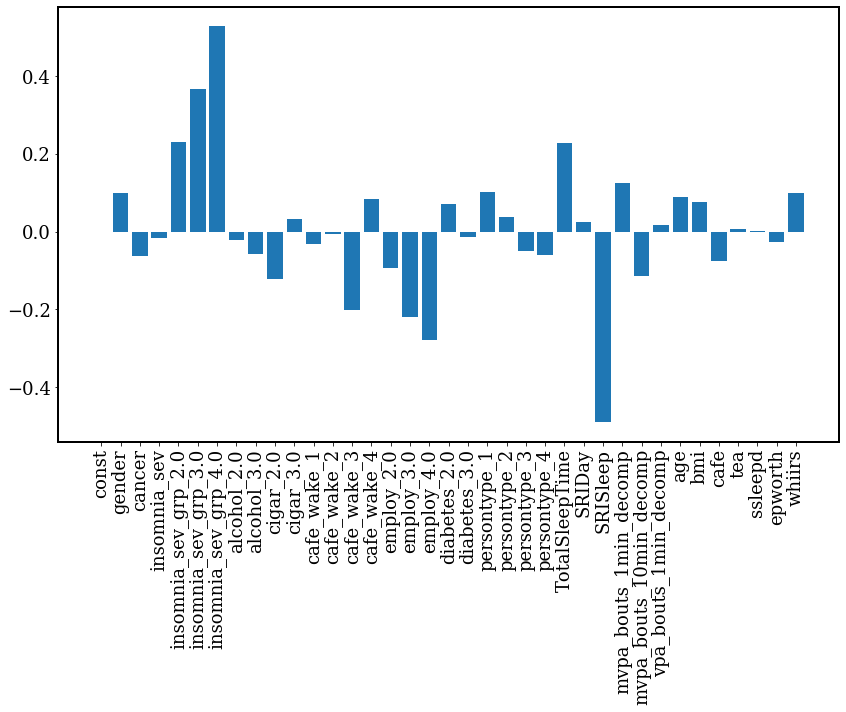

In [34]:
#Regression for Awakening
              
col3 = 'Awakening'
X_col3 = df_zipped.drop([col3,'TotalWakeTime','SleepEfficiency'],axis=1)
y_col3 = df_zipped[col3]

X_col3 = sm.add_constant(X_col3)

#Regression with sm
# Note the difference in argument order
model_col3 = sm.OLS(y_col3, X_col3).fit() ## sm.OLS(output, input)
predictions = model_col3.predict(X_col3)

# Print out the statistics
print(model_col3.summary())


#Regression with sklearn linear_model
lm = linear_model.LinearRegression()
model_lm_col3 = lm.fit(X_col3,y_col3)
predictions = lm.predict(X_col3)
#print(predictions)
importance = model_lm_col3.coef_
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([X_col3.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

                            OLS Regression Results                            
Dep. Variable:               SRISleep   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     15.37
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           2.32e-73
Time:                        09:41:21   Log-Likelihood:                -1180.2
No. Observations:                1002   AIC:                             2436.
Df Residuals:                     964   BIC:                             2623.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

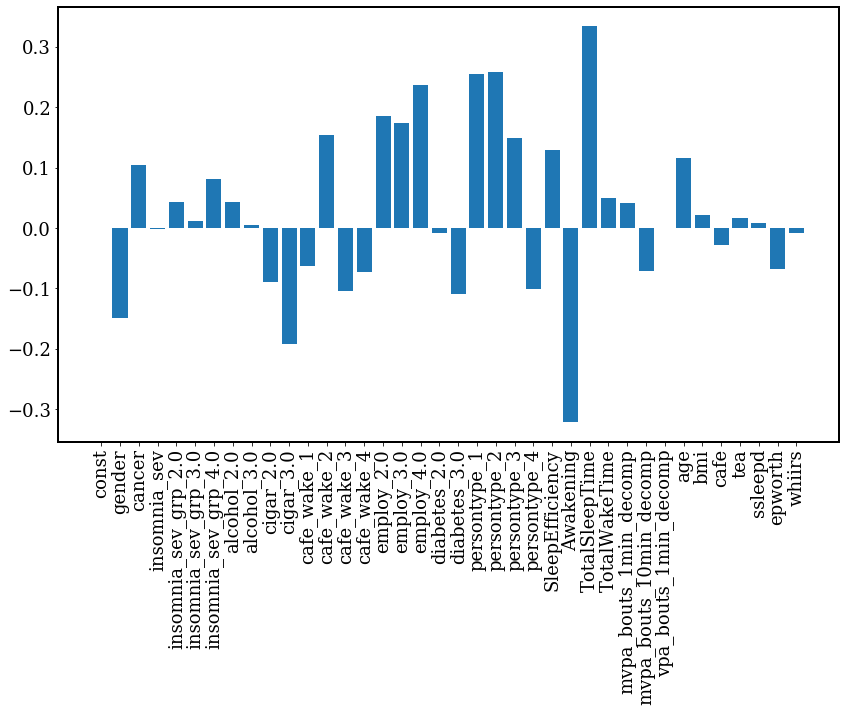

In [35]:
#Regression for SRISleep
              
col4 = 'SRISleep'
X_col4 = df_zipped.drop([col4,'SRIDay'],axis=1)
y_col4 = df_zipped[col4]

X_col4 = sm.add_constant(X_col4)

#Regression with sm
# Note the difference in argument order
model_col4 = sm.OLS(y_col4, X_col4).fit() ## sm.OLS(output, input)
predictions = model_col4.predict(X_col4)

# Print out the statistics
print(model_col4.summary())


#Regression with sklearn linear_model
lm = linear_model.LinearRegression()
model_lm_col4 = lm.fit(X_col4,y_col4)
predictions = lm.predict(X_col4)
#print(predictions)
importance = model_lm_col4.coef_
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([X_col4.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                 SRIDay   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     8.413
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           4.79e-38
Time:                        09:43:26   Log-Likelihood:                -1283.6
No. Observations:                1002   AIC:                             2643.
Df Residuals:                     964   BIC:                             2830.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

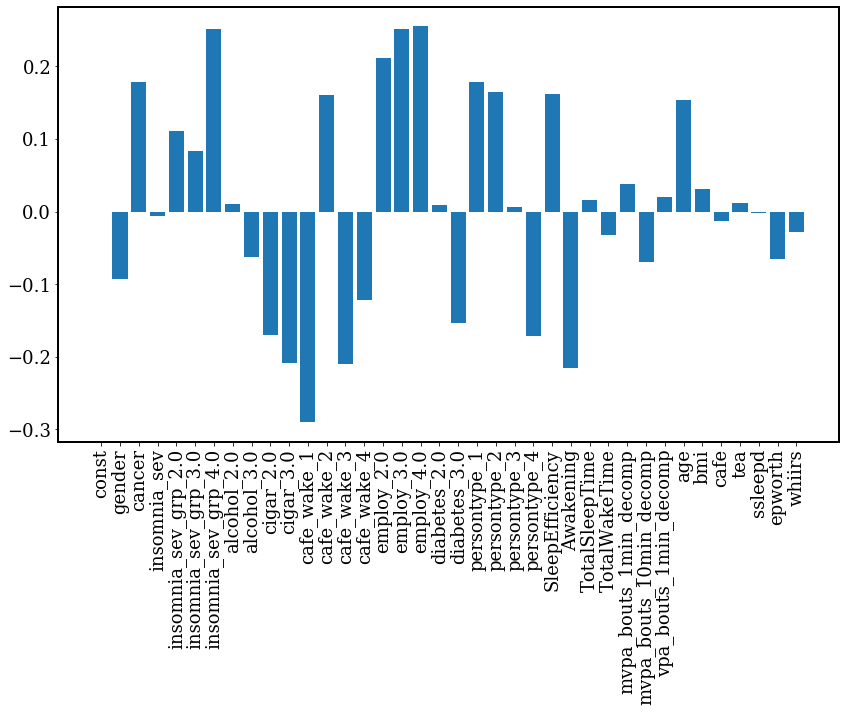

In [36]:
#Regression for SRISleep
              
col5 = 'SRIDay'
X_col5 = df_zipped.drop([col5,'SRISleep'],axis=1)
y_col5 = df_zipped[col5]

X_col5 = sm.add_constant(X_col5)

#Regression with sm
# Note the difference in argument order
model_col5 = sm.OLS(y_col5, X_col5).fit() ## sm.OLS(output, input)
predictions = model_col5.predict(X_col5)

# Print out the statistics
print(model_col5.summary())


#Regression with sklearn linear_model
lm = linear_model.LinearRegression()
model_lm_col5 = lm.fit(X_col5,y_col5)
predictions = lm.predict(X_col5)
#print(predictions)
importance = model_lm_col5.coef_
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([X_col5.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()